In [1]:
## processing
import numpy as np
import pandas as pd
from scipy import optimize
import scipy.stats as stats

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Functions

In [2]:
def find_center(df):
    x = df['posX']
    y = df['posY']
    data = np.vstack((x, y))

    kde = stats.kde.gaussian_kde(data)
    gx, gy = np.mgrid[x.min():x.max():128j, y.min():y.max():128j]
    gxy = np.dstack((gx, gy)) # shape is (128, 128, 2)
    z = np.apply_along_axis(kde, 2, gxy)
    z = z.reshape(128, 128)

    center_ix, center_iy = np.unravel_index(z.argmax(), z.shape)
    center_x = center_ix / 128 * (x.max() - x.min()) + x.min()
    center_y = center_iy / 128 * (y.max() - y.min()) + y.min()
    return center_x, center_y


def find_circle(x, xc, yc, r):
    y_upper = yc + np.sqrt(r**2 - (x - xc)**2)
    y_lower = yc - np.sqrt(r**2 - (x - xc)**2)
    return y_upper, y_lower


def in_circle(row, xc_2, yc_2, R_2):
    x_coord = row['posX']

    if x_coord < (xc_2 - R_2) or x_coord > (xc_2 + R_2):
        return 0
    else:
        upper_bound, lower_bound = find_circle(x_coord, xc_2, yc_2, R_2)
        y_coord = row['posY']
        if y_coord > upper_bound or y_coord < lower_bound:
            return 0
        else:
            return 1
        

def aster_fraction(row, dir_path):
    run_index = int(row['run'])
    len_run_index = len(str(run_index))
    fpath = dir_path + 'run{}/fiber_position.txt'.format((4 - len_run_index)*'0' + str(run_index))

    df = pd.read_table(fpath,
                skiprows=5,
                delim_whitespace=True,
                names=['class', 'identity', 'length', 'posX', 'posY', 'dirX', 'dirY', 'endToEnd', 'cosinus', 'organizer'])
    df = df.dropna(how='any')

    center_x, center_y = find_center(df)

    #col = df.apply(in_circle, args=(center_x, center_y, np.median(df['length'])/2), axis=1)
    col = df.apply(in_circle, args=(center_x, center_y, np.max(df['length'])/2), axis=1)
    df = df.assign(in_circle=col.values)

    return sum(df['in_circle']) / len(df)

## Building the full phase diagram

In [3]:
shape_list = np.arange(0.5, 7.1, 0.5)
scale_list = np.arange(0.5, 7.1, 0.5)

params = []
for shape in shape_list:
    for scale in scale_list:
        params.append((shape, scale))

df_list = []
for i in range(196):
    shape, scale = params[i]
    rv = {'run': i, 'shape': shape, 'scale': scale}
    df_list.append(rv)
df = pd.DataFrame(df_list)

In [4]:
dir_path = '~/thomsonlab/simulation/ms-simulations/2d-phase/'
col = df.apply(aster_fraction, axis=1, dir_path=dir_path)
df = df.assign(in_aster_frac=col.values)
df = df.groupby(['shape', 'scale']).mean().reset_index()

In [5]:
def f(row):
    if row['in_aster_frac'] > 0.5:
        val = 1
    else:
        val = 0
    return val

In [6]:
df['globally_contract'] = df.apply(f, axis=1)

In [7]:
df_global = df[df.globally_contract == 1]
df_local = df[df.globally_contract == 0]

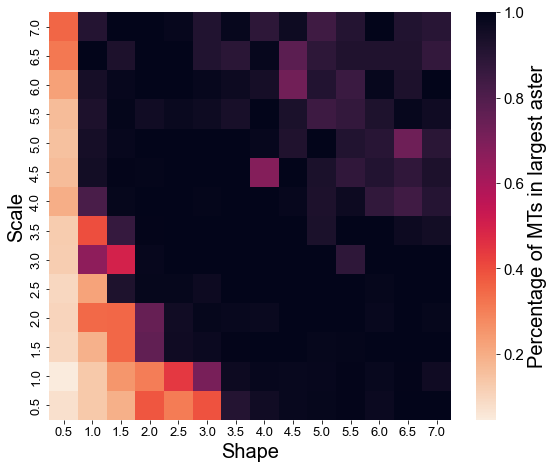

In [19]:
df_pivoted = df.pivot("shape", "scale", "in_aster_frac")

fig, ax = plt.subplots(figsize=(9,7.5))
fig.patch.set_facecolor('white')
ax = sns.heatmap(df_pivoted, cmap=sns.cm.rocket_r, cbar_kws={'label': 'Percentage of MTs in largest aster'})
ax.invert_yaxis()
ax.set_xlabel('Shape', fontsize=20)
ax.set_ylabel('Scale', fontsize=20)
ax.set_xticklabels(np.arange(0.5, 7.1, 0.5), fontsize=13)
ax.set_yticklabels(np.arange(0.5, 7.1, 0.5), fontsize=13)
ax.figure.axes[-1].yaxis.label.set_size(20)

cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=15)

plt.savefig('../figures/percolation-phase-diagram-2d.png', dpi=300)
plt.show()